In [1]:
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import dill
from typing import List
import scipy.stats as sts
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from scipy.stats import gaussian_kde

import util
from pathlib import Path
from class_manipulates_path import ManipulatePath
from class_preprocessing_refactor import Preprocessing
from class_format_data import FormatData
from som_anomaly_detector.anomaly_detection import AnomalyDetection
util.init()

current_path = sys.path[0]

In [2]:
def plot_variable(df, column_name, intervalos=None):
    """
    Plota um gráfico de dispersão para uma variável de um DataFrame.

    Parâmetros:
        - df: DataFrame pandas contendo os dados.
        - column_name: Nome da coluna que você deseja plotar.
        - intervalos: Lista de intervalos para plotar linhas verticais.
    """
    plt.figure(figsize=(20, 10))
    plt.scatter(df.index.values, df[column_name].values, color='darkcyan', alpha=0.5)
    plt.xlabel('Índice')
    plt.ylabel(column_name)
    plt.title(f'Gráfico de dispersão para a variável "{column_name}"')


    # Plotar linhas verticais para cada intervalo
    if intervalos:
        for intervalo in intervalos:
            plt.axvline(x=intervalo, linestyle='--', color='red')

    plt.show()

In [3]:
def class_and_file_generator(data_path, real=False, simulated=False, drawn=False):
    for class_path in data_path.iterdir():
        if class_path.is_dir():
            class_code = int(class_path.stem)
            for instance_path in class_path.iterdir():
                if (instance_path.suffix == '.csv'):
                    if (simulated and instance_path.stem.startswith('SIMULATED')) or \
                       (drawn and instance_path.stem.startswith('DRAWN')) or \
                       (real and (not instance_path.stem.startswith('SIMULATED')) and \
                       (not instance_path.stem.startswith('DRAWN'))):
                        yield class_code, instance_path

In [4]:
manipulate_path = ManipulatePath()

preprocessing = Preprocessing()

format_data = FormatData()

path_raw_data = manipulate_path.get_path_raw_data()

abnormal_classes_codes = [1, 2, 5, 6, 7, 8]

In [5]:
# Gets all real instances but maintains only those with any type of undesirable event
real_instances = pd.DataFrame(class_and_file_generator(path_raw_data, 
                                                       real=True,
                                                       simulated=False, 
                                                       drawn=False),
                              columns=['class_code', 'instance_path'])
real_instances = real_instances.loc[real_instances.iloc[:,0].isin(abnormal_classes_codes)].reset_index(drop=True)

In [6]:
real_instances[real_instances["class_code"] == 1]

,class_code,instance_path
0,1,c:\Users\marce\Documents\MEGA\0_PUC-Rio\2_Peri...
1,1,c:\Users\marce\Documents\MEGA\0_PUC-Rio\2_Peri...
2,1,c:\Users\marce\Documents\MEGA\0_PUC-Rio\2_Peri...
3,1,c:\Users\marce\Documents\MEGA\0_PUC-Rio\2_Peri...
4,1,c:\Users\marce\Documents\MEGA\0_PUC-Rio\2_Peri...


In [7]:
real_instances[real_instances["class_code"] == 1]["instance_path"].values

array([WindowsPath('c:/Users/marce/Documents/MEGA/0_PUC-Rio/2_Periodo/2_Data Science/2_Trabalho_Final/3_3W/1_data/1_raw_data/1/WELL-00001_20140124093303.csv'),
       WindowsPath('c:/Users/marce/Documents/MEGA/0_PUC-Rio/2_Periodo/2_Data Science/2_Trabalho_Final/3_3W/1_data/1_raw_data/1/WELL-00002_20140126161944.csv'),
       WindowsPath('c:/Users/marce/Documents/MEGA/0_PUC-Rio/2_Periodo/2_Data Science/2_Trabalho_Final/3_3W/1_data/1_raw_data/1/WELL-00006_20170731180930.csv'),
       WindowsPath('c:/Users/marce/Documents/MEGA/0_PUC-Rio/2_Periodo/2_Data Science/2_Trabalho_Final/3_3W/1_data/1_raw_data/1/WELL-00006_20170731220432.csv'),
       WindowsPath('c:/Users/marce/Documents/MEGA/0_PUC-Rio/2_Periodo/2_Data Science/2_Trabalho_Final/3_3W/1_data/1_raw_data/1/WELL-00006_20180617200257.csv')],
      dtype=object)

In [8]:
falha = 1

file_paths = real_instances[real_instances["class_code"] == falha]["instance_path"].values
df_output = pd.DataFrame()

for file_path in file_paths:
    df_data = pd.read_csv(file_path)

    df_data = FormatData.set_index_dataframe(df_data=df_data,
                                         column_name="timestamp")
    quantidade = (df_data['class'] == falha).sum()
    print(f"1 se repete {quantidade}")
    print(f"Index min {df_data.index.min()} index max {df_data.index.max()}")
    
    df_output = pd.concat([df_output, df_data], axis=0)

1 se repete 4603
Index min 2014-01-24 09:33:03 index max 2014-01-25 01:47:30
1 se repete 2929
Index min 2014-01-26 16:19:44 index max 2014-01-26 23:00:00
1 se repete 1205
Index min 2017-07-31 18:09:30 index max 2017-08-01 20:45:00
1 se repete 861
Index min 2017-07-31 22:04:32 index max 2017-08-01 20:19:27
1 se repete 819
Index min 2018-06-17 20:02:57 index max 2018-06-18 11:00:00


In [9]:
df_output = df_output[~df_output.index.duplicated()]

In [10]:
df_output.head()

,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,T-JUS-CKGL,QGL,class
timestamp,,,,,,,,,
2014-01-24 09:33:03,0.0,18433410.0,116.8718,9397031.0,74.80031,-300917.8,NaN,0.0,0.0
2014-01-24 09:33:04,0.0,18433410.0,116.8718,9397031.0,74.80031,-300917.8,NaN,0.0,0.0
2014-01-24 09:33:05,0.0,18433410.0,116.8718,9397032.0,74.80031,-300917.8,NaN,0.0,0.0
2014-01-24 09:33:06,0.0,18433410.0,116.8718,9397033.0,74.80031,-300917.8,NaN,0.0,0.0
2014-01-24 09:33:07,0.0,18433410.0,116.8718,9397033.0,74.80031,-300917.8,NaN,0.0,0.0


In [11]:
df_aux = df_output.drop(columns=["QGL", "T-JUS-CKGL"])
df_aux

,P-PDG,P-TPT,T-TPT,P-MON-CKP,T-JUS-CKP,P-JUS-CKGL,class
timestamp,,,,,,,
2014-01-24 09:33:03,0.000000e+00,18433410.0,116.8718,9397031.0,74.80031,-300917.8,0.0
2014-01-24 09:33:04,0.000000e+00,18433410.0,116.8718,9397031.0,74.80031,-300917.8,0.0
2014-01-24 09:33:05,0.000000e+00,18433410.0,116.8718,9397032.0,74.80031,-300917.8,0.0
2014-01-24 09:33:06,0.000000e+00,18433410.0,116.8718,9397033.0,74.80031,-300917.8,0.0
2014-01-24 09:33:07,0.000000e+00,18433410.0,116.8718,9397033.0,74.80031,-300917.8,0.0
...,...,...,...,...,...,...,...
2018-06-18 10:59:56,-1.180116e+42,20647810.0,118.2188,10136700.0,71.27952,4108865.0,1.0
2018-06-18 10:59:57,-1.180116e+42,20647810.0,118.2194,10137410.0,71.27949,4108866.0,1.0
2018-06-18 10:59:58,-1.180116e+42,20647810.0,118.2201,10138120.0,71.27946,4108866.0,1.0


In [12]:
for column_name in df_aux.columns:
    percent = Preprocessing.check_null_dataframe(df_data=df_aux, column_name=column_name)
    print(f"{column_name} null data is {percent}")

P-PDG null data is 0.0
P-TPT null data is 0.0
T-TPT null data is 0.0
P-MON-CKP null data is 0.0
T-JUS-CKP null data is 0.0
P-JUS-CKGL null data is 0.0
class null data is 4.459575935183589


In [13]:
df_aux = df_aux.dropna()
df_aux.shape

(221692, 7)

In [14]:
for column_name in df_aux.columns:
    percent = Preprocessing.check_column_low_variance(df_data=df_output, column_name=column_name)
    print(f"{column_name} low variance is {percent}")

P-PDG low variance is 0
P-TPT low variance is 0
T-TPT low variance is 0
P-MON-CKP low variance is 0
T-JUS-CKP low variance is 0
P-JUS-CKGL low variance is 0
class low variance is 0


In [15]:
df_aux["class"] = df_aux["class"].replace(101, 1)

C:\Users\marce\AppData\Local\Temp\ipykernel_52604\311632643.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aux["class"] = df_aux["class"].replace(101, 1)


In [16]:
contagem_classes = df_aux['class'].value_counts()

# Calcular a porcentagem de cada classe
porcentagem_classes = contagem_classes / len(df_aux) * 100
porcentagem_classes

class
0.0    66.432257
1.0    33.567743
Name: count, dtype: float64

In [17]:
# Separar as features (X) e os rótulos (y)
X = df_aux.drop('class', axis=1)
y = df_aux['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

df_train = X_train.copy()
df_train["class"] = y_train

df_test = X_test.copy()
df_test["class"] = y_test

In [18]:
full_data_train = df_train.copy()
norm_data_train = df_train[df_train["class"] == 0].copy()

norm_data_train = norm_data_train.drop(columns=["class"])

anom_data_train = df_train[(df_train["class"] == 1)].copy()
anom_data_train = anom_data_train.drop(columns=["class"])

In [23]:
scaler = RobustScaler().fit(df_train.drop(columns=["class"]))

In [24]:
norm_data_train = scaler.transform(norm_data_train)
anom_data_train = scaler.transform(anom_data_train)

In [20]:
anomaly_detector = AnomalyDetection((10, 10), 6, 8, 0.001, 2, 0.001, 10, 3)

In [26]:
anom_data_train

array([[ 1.00000000e+00, -2.43048364e+00,  1.20668722e+00,
        -8.06783047e-01,  5.66927224e-01,  1.86322608e-03],
       [ 0.00000000e+00, -2.50725061e+01,  9.23010214e-01,
        -4.42670661e-01,  2.19645962e+01,  7.25305678e-01],
       [ 1.00000000e+00, -2.50525000e-01,  6.30468298e-01,
        -7.94804178e-01,  5.58084436e-02, -2.21643993e-03],
       ...,
       [ 1.00000000e+00, -6.39617832e-01,  8.65773752e-01,
        -7.96538032e-01,  1.56038375e-01, -2.89412302e-03],
       [ 1.00000000e+00, -6.39617832e-01,  8.65773752e-01,
        -7.96694980e-01,  1.65107363e-01, -2.66324626e-03],
       [ 0.00000000e+00, -2.51230343e+01,  9.41029100e-01,
        -4.59717754e-01,  2.19645962e+01,  7.26193312e-01]])

In [27]:
N_ITER_TO_FIT = 5000

anomaly_detector.fit(norm_data_train, N_ITER_TO_FIT)
anomaly_metrics = anomaly_detector.evaluate(anom_data_train)

(array([58., 15., 12.,  5.,  5.,  2.,  2.,  0.,  0.,  1.]),
 array([   0.,  754., 1508., 2262., 3016., 3770., 4524., 5278., 6032.,
        6786., 7540.]),
 <BarContainer object of 10 artists>)

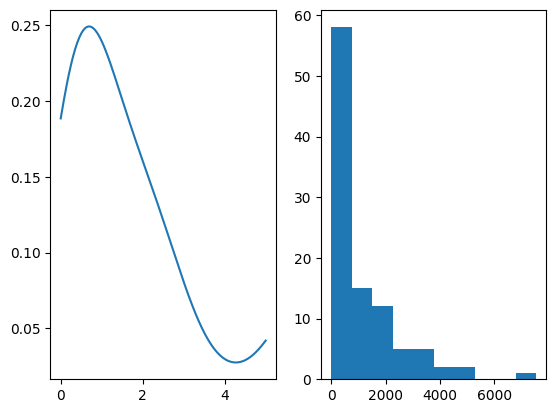

In [30]:
plt.subplot(121)
density = gaussian_kde(anomaly_metrics)
xs = np.linspace(0, 5, 200)
plt.plot(xs, density(xs))

plt.subplot(122)
plt.hist(anomaly_detector.bmu_counts)

In [94]:
threshold = 0.1
selector = anomaly_metrics > threshold

In [95]:
len(anomaly_metrics)

52092

In [62]:
np.sum(selector)

51362

In [49]:
full_data_train_norm = scaler.transform(full_data_train.drop(columns=["class"]))

In [50]:
full_data_train_norm

array([[ 1.00000000e+00, -2.43048364e+00,  1.20668722e+00,
        -8.06783047e-01,  5.66927224e-01,  1.86322608e-03],
       [-2.63077865e+34,  1.54784309e+01, -5.01059934e-02,
         3.08579491e-01, -1.86657696e+00,  6.37354048e-01],
       [ 0.00000000e+00, -2.50725061e+01,  9.23010214e-01,
        -4.42670661e-01,  2.19645962e+01,  7.25305678e-01],
       ...,
       [-2.63077865e+34,  1.54784309e+01, -3.82539988e-02,
         3.09458222e-01, -1.84199578e+00,  6.35670304e-01],
       [ 1.00000000e+00,  0.00000000e+00,  5.37964926e-01,
        -7.92507381e-01,  1.89238475e-02,  2.41006367e-03],
       [ 0.00000000e+00,  3.83770699e-01, -1.02139140e+00,
         2.06704821e-01, -9.41533123e-01, -3.67409625e-01]])

In [51]:
anomaly_metrics_train = anomaly_detector.evaluate(full_data_train_norm)

full_data_train["PRED"] = 0

full_data_train.loc[anomaly_metrics_train > threshold, "PRED"] = 1

In [98]:
full_data_train["PRED"].unique()

array([1, 0], dtype=int64)

In [90]:
full_data_train["class"]

timestamp
2017-08-01 19:45:13    1.0
2018-06-18 02:18:28    0.0
2014-01-26 22:45:15    1.0
2014-01-24 20:17:48    0.0
2017-07-31 18:59:31    0.0
                      ... 
2018-06-17 21:10:02    0.0
2017-07-31 20:54:53    0.0
2018-06-18 01:19:39    0.0
2017-08-01 05:08:21    0.0
2014-01-24 19:12:32    0.0
Name: class, Length: 155184, dtype: float64

In [99]:
accuracy_score(full_data_train['class'].values, full_data_train["PRED"].values)

0.9633854005567585

In [100]:
f1_score(full_data_train['class'].values,  full_data_train["PRED"].values, average="micro")

0.9633854005567585

In [101]:
precision = precision_score(full_data_train['class'].values,  full_data_train["PRED"].values, average=None)
recall = recall_score(full_data_train['class'].values,  full_data_train["PRED"].values, average=None)
f1 = f1_score(full_data_train['class'].values,  full_data_train["PRED"].values, average=None)

for i in range(len(precision)):
    print(f'Classe {i}:')
    print(f'Precision: {precision[i]}')
    print(f'Recall: {recall[i]}')
    print(f'F1-score: {f1[i]}\n')

Classe 0:
Precision: 0.9834147212958552
Recall: 0.9610930043068328
F1-score: 0.9721257432154

Classe 1:
Precision: 0.9263117283950617
Recall: 0.9679221377562773
F1-score: 0.9466599076264505



In [103]:
full_data_test_norm = scaler.transform(df_test.drop(columns=["class"]))

In [104]:
full_data_test_norm

array([[-2.63077865e+34,  1.54784309e+01, -7.20755444e-02,
         3.05562951e-01, -1.86293444e+00,  6.44772689e-01],
       [ 1.00000000e+00, -1.02338853e+00,  9.32838697e-01,
        -7.97198319e-01,  2.18294685e-01, -1.92278492e-03],
       [ 0.00000000e+00,  3.83770699e-01, -1.01888611e+00,
         2.06705112e-01, -9.41749995e-01, -3.67409625e-01],
       ...,
       [ 0.00000000e+00, -2.42203876e+01,  6.48198111e-01,
        -4.27129506e-01,  2.19645962e+01,  7.29646805e-01],
       [ 1.00000000e+00, -1.28244177e-02,  6.02235498e-01,
        -7.94207427e-01,  2.88509971e-02, -1.22693523e-03],
       [-2.63077865e+34,  1.57342781e+01, -8.02659472e-02,
         3.14095241e-01, -1.86676119e+00,  6.31149120e-01]])

In [105]:
anomaly_metrics_test = anomaly_detector.evaluate(full_data_test_norm)

df_test["PRED"] = 0

df_test.loc[anomaly_metrics_test > threshold, "PRED"] = 1

In [107]:
df_test["PRED"].unique

<bound method Series.unique of timestamp
2018-06-18 06:37:37    0
2017-08-01 15:12:58    1
2014-01-24 19:12:16    0
2014-01-24 10:16:30    0
2014-01-24 17:03:06    0
                      ..
2018-06-18 07:54:06    0
2017-08-01 02:36:02    0
2014-01-26 21:34:49    1
2017-08-01 09:44:32    0
2018-06-17 20:04:22    0
Name: PRED, Length: 66508, dtype: int64>

In [108]:
df_test["class"]

timestamp
2018-06-18 06:37:37    0.0
2017-08-01 15:12:58    1.0
2014-01-24 19:12:16    0.0
2014-01-24 10:16:30    0.0
2014-01-24 17:03:06    0.0
                      ... 
2018-06-18 07:54:06    0.0
2017-08-01 02:36:02    0.0
2014-01-26 21:34:49    1.0
2017-08-01 09:44:32    1.0
2018-06-17 20:04:22    0.0
Name: class, Length: 66508, dtype: float64

In [109]:
accuracy_score(df_test['class'].values, df_test["PRED"].values)

0.9635682925362362

In [110]:
precision = precision_score(df_test['class'].values,  df_test["PRED"].values, average=None)
recall = recall_score(df_test['class'].values,  df_test["PRED"].values, average=None)
f1 = f1_score(df_test['class'].values,  df_test["PRED"].values, average=None)

In [111]:
for i in range(len(precision)):
    print(f'Classe {i}:')
    print(f'Precision: {precision[i]}')
    print(f'Recall: {recall[i]}')
    print(f'F1-score: {f1[i]}\n')

Classe 0:
Precision: 0.9829308909242298
Recall: 0.961863160038929
F1-score: 0.9722829133254783

Classe 1:
Precision: 0.9275953936060501
Recall: 0.966942889137738
F1-score: 0.9468605390705528

